## Persiapan Data

In [1]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk membaca data dari file teks
def load_words(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return words

# Fungsi untuk membaca dan memetakan slang words
def load_slang_words(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        slang_dict = json.loads(file.read())
    return slang_dict

# Memuat data dari file
root_words = load_words('../Dataset/indonesian_word/combined_root_words.txt')
stop_words = load_words('../Dataset/indonesian_word/combined_stop_words.txt')
slang_dict = load_slang_words('../Dataset/indonesian_word/combined_slang_words.txt')

# Gabungkan semua kata untuk pembentukan kosakata
all_words = list(set(root_words + stop_words + list(slang_dict.keys()) + list(slang_dict.values())))

# Inisialisasi tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)

# Konversi kata menjadi urutan angka
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


## Membuat Model Embedding

In [2]:
# Parameter model
embedding_dim = 50
max_length = 1  # Karena kita hanya punya kata-kata individu, panjang maksimum adalah 1

# Membuat model embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten()
])

# Menampilkan ringkasan model
model.summary()

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             1465950   
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
Total params: 1,465,950
Trainable params: 1,465,950
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [3]:
# Menyiapkan input data
sequences = tokenizer.texts_to_sequences(all_words)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Lihat embedding untuk beberapa kata
for word in ['mahal', 'murah', 'baik']:
    idx = tokenizer.texts_to_sequences([word])[0][0]
    embedding_vector = model.predict(pad_sequences([[idx]], maxlen=max_length, padding='post'))
    print(f'Embedding untuk kata "{word}":\n{embedding_vector}\n')


Embedding untuk kata "mahal":
[[-0.04454777 -0.02571614 -0.00543592 -0.04577462 -0.04265212  0.04837194
  -0.00851872 -0.00276731  0.045716    0.02621793  0.03101357 -0.03779682
  -0.00869269 -0.01609112  0.00671338 -0.02978214  0.04280284  0.01175842
  -0.03840422 -0.01609857  0.02664519 -0.04512572  0.0339175   0.03926435
   0.03722023  0.02945182  0.02711597  0.03579146  0.01846174 -0.03775255
   0.00681976 -0.01602838 -0.01781926 -0.00700713 -0.04005839 -0.03438783
   0.01217683  0.00335155  0.02173399 -0.01115986 -0.02884315 -0.04796621
   0.04738528 -0.00513012  0.04110387 -0.04720877  0.04899606  0.01110261
   0.02643755  0.00662973]]

Embedding untuk kata "murah":
[[ 0.0406988  -0.02241386  0.02550037  0.03773496  0.03628441 -0.04248972
   0.00348005  0.01055853  0.03495789  0.01835939  0.0379486   0.03204579
   0.01761839 -0.02925067 -0.0148098  -0.0229777  -0.0377943   0.03132052
   0.00087293  0.01788241  0.03887791 -0.01164009 -0.00208034  0.04889716
  -0.03531329  0.025633

In [4]:
# Menyimpan model
model.save('../saved_model/base_model_saved/embedding_model.h5')

# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TensorFlow Lite
with open('../saved_model/base_model_saved/embedding_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp6pdtte1y\assets


# Visualize

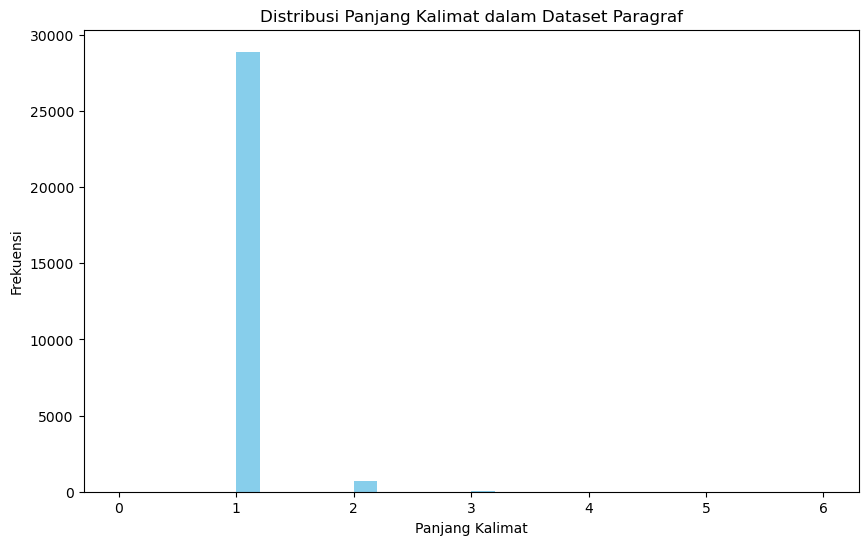

In [6]:
import matplotlib.pyplot as plt

# Menghitung panjang kalimat
sentence_lengths = [len(seq) for seq in sequences]

# Plot distribusi panjang kalimat
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue')
plt.title('Distribusi Panjang Kalimat dalam Dataset Paragraf')
plt.xlabel('Panjang Kalimat')
plt.ylabel('Frekuensi')
plt.show()


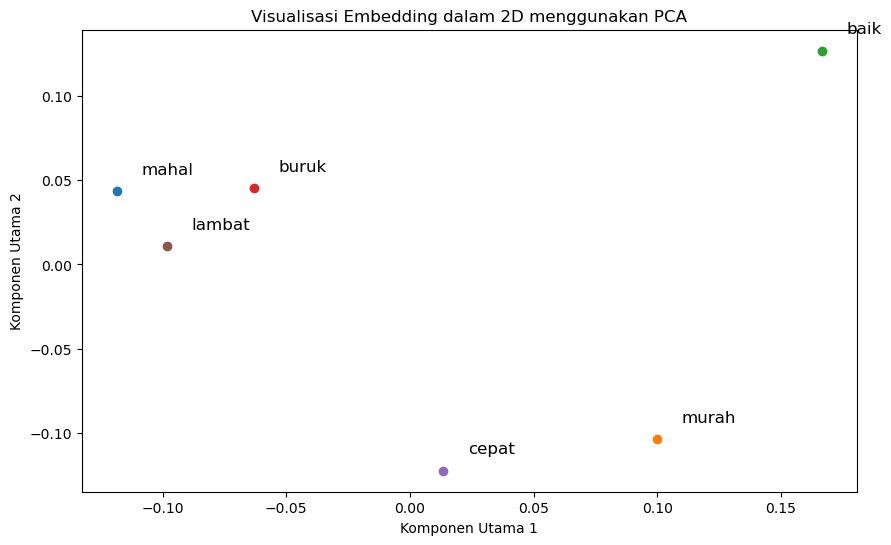

In [7]:
from sklearn.decomposition import PCA
import numpy as np

# Mendapatkan embedding dari model untuk beberapa kata
words_to_visualize = ['mahal', 'murah', 'baik', 'buruk', 'cepat', 'lambat']
word_indices = [tokenizer.word_index[word] for word in words_to_visualize]
embeddings = model.layers[0].get_weights()[0]

# Mengambil embedding dari kata-kata yang dipilih
selected_embeddings = np.array([embeddings[idx] for idx in word_indices])

# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(selected_embeddings)

# Plot embedding dalam 2D
plt.figure(figsize=(10, 6))
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0]+0.01, reduced_embeddings[i, 1]+0.01, word, fontsize=12)

plt.title('Visualisasi Embedding dalam 2D menggunakan PCA')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.show()
